# Experiments on a basic neural network

We will setup a two layers linear network with one hyperbolic tangent module between these layers, and one sigmoid module after the last hidden layer of the network.

In [2]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), ".."))

In [3]:
from pyldl.activations import Sigmoid, Tanh
from pyldl.losses import MSELoss
from pyldl.modules import Linear

## Dataset and Network

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_data(data, labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols, marks = ["red", "green", "blue", "orange", "black", "cyan"], [".", "+", "*", "o", "x", "^"]
    if labels is None:
        plt.scatter(data[:,0], data[:,1], marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l, 0], data[labels==l, 1], c=cols[i], marker=marks[i])

def plot_frontiere(data, f, step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid, x, y = make_grid(data=data,step=step)
    plt.contourf(x, y, f(grid).reshape(x.shape), colors=('gray','blue'), levels=[-1,0,1])

def make_grid(data=None, xmin=-5, xmax=5, ymin=-5, ymax=5, step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:, 0]), np.min(data[:, 0]), np.max(data[:, 1]), np.min(data[:, 1])
    x, y = np.meshgrid(np.arange(xmin, xmax, (xmax-xmin)*1. / step), np.arange(ymin, ymax, (ymax-ymin)*1. / step))
    grid = np.c_[x.ravel(), y.ravel()]
    return grid, x, y

def gen_arti(centerx=1, centery=1, sigma=0.1, nbex=1000, data_type=0, epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos = np.random.multivariate_normal([centerx, centerx],np.diag([sigma, sigma]), nbex//2)
         xneg = np.random.multivariate_normal([-centerx, -centerx],np.diag([sigma, sigma]), nbex//2)
         data = np.vstack((xpos ,xneg))
         y = np.hstack((np.ones(nbex//2), -np.ones(nbex//2)))
         
    if data_type == 1:
        #melange de 4 gaussiennes
        xpos = np.vstack((np.random.multivariate_normal([centerx, centerx],np.diag([sigma, sigma]), nbex//4), np.random.multivariate_normal([-centerx, -centerx], np.diag([sigma,sigma]), nbex//4)))
        xneg = np.vstack((np.random.multivariate_normal([-centerx, centerx],np.diag([sigma, sigma]), nbex//4), np.random.multivariate_normal([centerx, -centerx], np.diag([sigma,sigma]), nbex//4)))
        data = np.vstack((xpos,xneg))
        y = np.hstack((np.ones(nbex//2), -np.ones(nbex//2)))

    if data_type ==2 :
        #echiquier
        data = np.reshape(np.random.uniform(-4, 4, 2*nbex), (nbex, 2))
        y = np.ceil(data[:, 0]) + np.ceil(data[:, 1])
        y = 2*(y % 2)-1
    # un peu de bruit
    data[:, 0] += np.random.normal(0, epsilon, nbex)
    data[:, 1] += np.random.normal(0, epsilon, nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data = data[idx,:]
    y = y[idx]
    return data, y.reshape(-1, 1)


In [5]:
X, y = gen_arti(data_type=1)
y = np.where(y == -1, 0, 1)

In [6]:
network = [Linear(X.shape[1], 100), Tanh(), Linear(100, 1), Sigmoid()]
loss = MSELoss()

## Gradient Descent

In [7]:
def gradient_descent(X, y, n_iter_max=1000, gradient_step=1e-4):
    losses = []
    for _ in range(n_iter_max):
        z1 = network[0](X)
        a1 = network[1](z1)
        z2 = network[2](a1)
        a2 = network[3](z2)

        loss_value = loss.forward(y, a2)
        losses.append(loss_value.mean())

        delta_loss = loss.backward(y, a2)
        delta_sig = network[3].backward_delta(z2, delta_loss)
        delta_lin2 = network[2].backward_delta(a1, delta_sig)
        delta_tan = network[1].backward_delta(z1, delta_lin2)

        network[2].backward_update_gradient(a1, delta_sig)
        network[0].backward_update_gradient(X, delta_tan)

        network[2].update_parameters(gradient_step)
        network[0].update_parameters(gradient_step)

        network[2].zero_grad()
        network[0].zero_grad()
    return losses

In [8]:
def predict(X):
    z1 = network[0].forward(X)
    a1 = network[1].forward(z1)
    z2 = network[2].forward(a1)
    a2 = network[3].forward(z2)
    return np.where(a2 > 0.5, 1, 0)

def accuracy_score(y, yhat):
    return np.mean(y == yhat)

print(f"Accuracy: {accuracy_score(y, predict(X))}")

Accuracy: 0.258


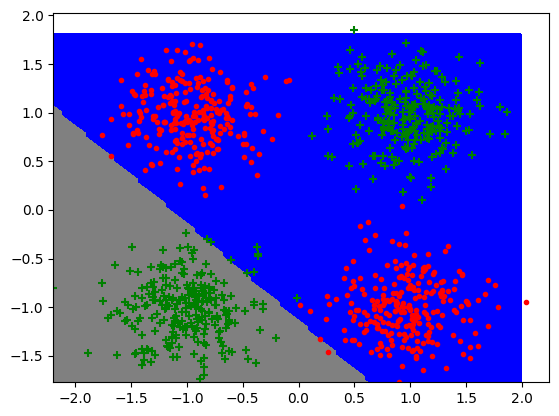

In [9]:
plot_frontiere(X, predict, step=100)
plot_data(X, y)